/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mmc/anaconda3/envs/CPR_YOLO/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


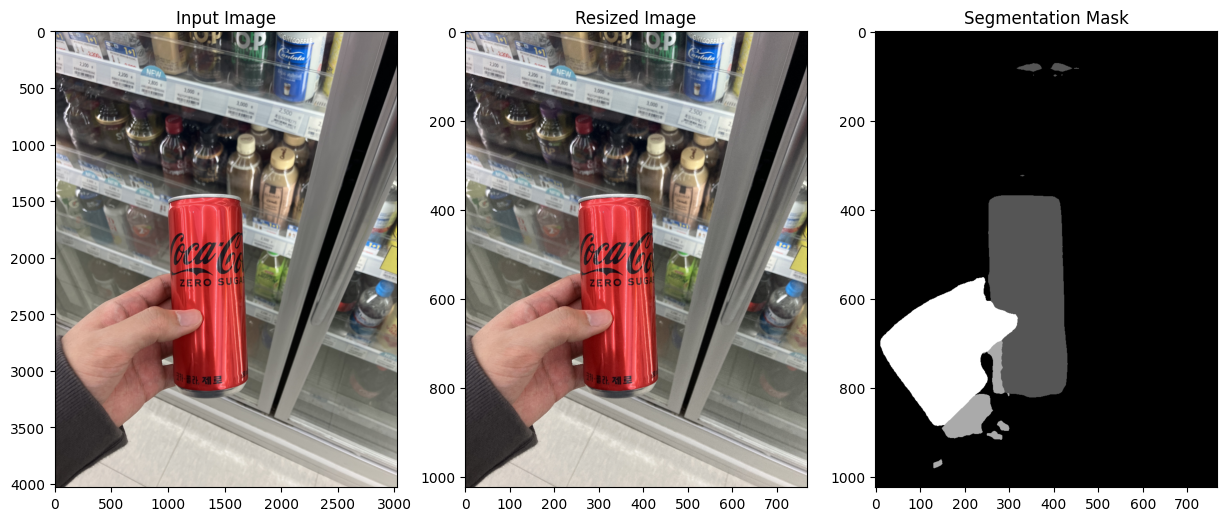

SyntaxError: 'return' outside function (2317822412.py, line 82)

In [38]:
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 로드 및 전처리
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((1024, 768)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    img_tensor = preprocess(img)
    img_resized = cv2.resize(img, (768, 1024)) 
    img_tensor = img_tensor.unsqueeze(0)  # 배치 차원 추가
    return img, img_tensor, img_resized

# 추론 함수
def predict(model, image_tensor):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)['out'][0]
    output_predictions = output.argmax(0)
    return output_predictions.byte().cpu().numpy()

# 클래스 매핑 시각화 함수
def visualize_classes(mask):
    classes = np.unique(mask)
    for cls in classes:
        print(f"Class {cls}: {CUSTOM_CLASSES[cls]}")

# 분할 결과 시각화
def visualize_result(img, mask, img_resized):
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.title("Resized Image")
    plt.imshow(img_resized)
    plt.subplot(1, 3, 3)
    plt.title("Segmentation Mask")
    plt.imshow(mask, cmap='gray')
    plt.show()

# 마스크를 사용하여 이미지를 크롭하고 배경을 흰색으로 설정
def apply_mask(img, mask):
    # masked_img = np.where((mask[..., None] == 2), img, 255) #snack만 
    masked_img = np.where((mask[..., None] == 0) | (mask[..., None] == 3), 255, img)
    return masked_img

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUSTOM_CLASSES = ['background', 'drink', 'snack', 'Human_hand']

# 모델 준비
num_classes = len(CUSTOM_CLASSES)
model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(512, num_classes, kernel_size=1)  # num_classes는 커스텀 데이터셋의 클래스 수
model = model.to(device)

# 모델 로드 및 GPU 설정
model_path = '/home/mmc/disk2/duck/cap/DeepLabV3+/pt/best_fcn50.pt'  # pt 파일 경로 지정
model.load_state_dict(torch.load(model_path))
model.eval()

image_path = '/home/mmc/disk2/duck/cap/data/drink_test/코카콜라제로225.jpg'  # 분할할 이미지 경로
img, img_tensor, img_resized = load_image(image_path)
mask = predict(model, img_tensor)
masked_img = apply_mask(img_resized, mask)

visualize_result(img, mask, img_resized)
# visualize_classes(mask)  # 클래스 이름 출력


In [5]:
import os
import torch
import torchvision
from torchvision import transforms
import cv2
import numpy as np
import copy
from scipy.ndimage import label, binary_fill_holes

# 이미지 로드 및 전처리
def load_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((1024, 768)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img)
    img_resized = cv2.resize(img, (768, 1024))
    img_tensor = img_tensor.unsqueeze(0)  # 배치 차원 추가
    return img, img_tensor, img_resized

# 추론 함수
def predict(model, image_tensor, device):
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = model(image_tensor)['out'][0]
    output_predictions = output.argmax(0)
    return output_predictions.byte().cpu().numpy()

# 더 큰 클래스만 남기고 나머지를 배경으로 전환
def select_largest_class(mask, class1_id, class2_id):
    class1_size = np.sum(mask == class1_id)
    class2_size = np.sum(mask == class2_id)
    if class1_size > class2_size:
        mask[mask == class2_id] = 0  # 작은 클래스는 배경으로 설정
        return class1_id
    else:
        mask[mask == class1_id] = 0  # 작은 클래스는 배경으로 설정
        return class2_id

# 같은 클래스 중 가장 큰 바운딩 박스만 남기기
def select_largest_bbox(mask, class_id):
    labeled_mask, num_labels = label(mask == class_id)
    largest_area = 0
    largest_label = 0
    for i in range(1, num_labels + 1):
        area = np.sum(labeled_mask == i)
        if area > largest_area:
            largest_area = area
            largest_label = i
    mask[mask == class_id] = 0  # 모든 객체를 배경으로 설정
    mask[labeled_mask == largest_label] = class_id  # 가장 큰 바운딩 박스만 남기기
    return mask

# 마스크를 사용하여 이미지를 크롭하고 배경을 흰색으로 설정
def apply_mask(img, mask):
    mask[mask == 3] = 0  # 3번 클래스를 0으로 변환
    mask = binary_fill_holes(mask).astype(np.uint8)
    masked_img = np.where(mask[..., None] == 0, 255, img)
    return masked_img, mask

# 작은 객체를 제거하고 각각 크롭
def crop_individual_objects(masked_img, mask, class_id, min_size=(50, 50)):
    labeled_mask, num_labels = label(mask == class_id)
    crops = []
    for i in range(1, num_labels + 1):
        y, x = np.where(labeled_mask == i)
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()
        if (x_max - x_min) >= min_size[0] and (y_max - y_min) >= min_size[1]:  # 최소 크기 필터링
            crop = masked_img[y_min:y_max, x_min:x_max]
            crops.append(crop)
        else:
            # 작은 객체를 백그라운드로 채우기
            mask[y_min:y_max, x_min:x_max] = 0
    masked_img = apply_mask(masked_img, mask)  # 작은 객체 제거 후 다시 마스크 처리
    return masked_img, crops

# 모델 로드 함수
def load_model(model_path, model, device='cuda'):
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CUSTOM_CLASSES = ['background', 'drink', 'snack', 'Human_hand']

def process_images_in_folder(folder_path, model, device, output_folder):
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        print(f'Processing {image_path}')
        
        try:
            # 이미지 로드 및 전처리
            original_img, img_tensor, img_resized = load_image(image_path)
        except ValueError as e:
            print(e)
            continue

        # 분할 수행
        original_mask = predict(model, img_tensor, device)
        original_mask_copy = copy.deepcopy(original_mask)

        # snack과 drink 클래스 중 더 큰 것을 남기고 나머지는 배경으로 전환
        remaining_class_id = select_largest_class(original_mask, class1_id=2, class2_id=1)

        # hand 클래스가 식별된 경우에만 가장 큰 바운딩 박스만 남기기
        if np.any(original_mask == 3):
            mask = select_largest_bbox(original_mask, class_id=remaining_class_id)
        else:
            print(f'{CUSTOM_CLASSES[remaining_class_id]} corner')
            continue

        # 작은 객체를 제거하고 각각 크롭
        masked_img, individual_crops = crop_individual_objects(img_resized, mask, class_id=remaining_class_id, min_size=(50, 50))

        masked_img, mask = apply_mask(img_resized, mask)

        # 224x224 사이즈로 변환
        masked_img_resized = cv2.resize(masked_img, (224, 224))

        # 결과 이미지 저장
        output_image_path = os.path.join(output_folder, f'masked_{image_name}')
        cv2.imwrite(output_image_path, cv2.cvtColor(masked_img_resized, cv2.COLOR_RGB2BGR))

if __name__ == "__main__":
    image_folder_path = '/home/mmc/disk2/duck/cap/cnn/snack_2/images/train/'
    model_path = '/home/mmc/disk2/duck/cap/DeepLabV3+/pt/best_dl50_4:3.pt'
    output_folder = '/home/mmc/disk2/duck/cap/cnn/snack_2/masked_images/train/'

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 분할 모델 준비
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
    model.classifier[4] = torch.nn.Conv2d(256, len(CUSTOM_CLASSES), kernel_size=1)
    model = load_model(model_path, model, device)

    # 폴더 내 모든 이미지 처리
    process_images_in_folder(image_folder_path, model, device, output_folder)


Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0082.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0038.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0061.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0049.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0097.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0036.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0090.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0027.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0039.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0096.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0050.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0051.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0025.jpg
Processing /home/mmc/disk2/duck/cap/cnn/snack_2/images/train/0020.jpg
Processing /home/mmc

In [13]:
import chardet
import pandas as pd

# 기존 CSV 파일 경로
input_file = '/home/mmc/disk2/duck/cap/cnn/snack_2/images/train/snack.csv'

# 변환된 CSV 파일 경로
output_file = '/home/mmc/disk2/duck/cap/cnn/snack_2/images/train/snack.csv'

# 파일의 인코딩 감지
with open(input_file, 'rb') as f:
    result = chardet.detect(f.read())
    file_encoding = result['encoding']

# 감지된 인코딩을 사용하여 CSV 파일 읽기
df = pd.read_csv(input_file, encoding=file_encoding)

# UTF-8 인코딩으로 CSV 파일 저장
df.to_csv(output_file, index=False, encoding='utf-8-sig')


In [26]:
import os
from PIL import Image

# 원본 이미지가 저장된 디렉토리 경로
source_directory = "/home/mmc/disk2/duck/cap/cnn/snack_2/images_224/val"
# 크기가 변경된 이미지를 저장할 디렉토리 경로
target_directory = "/home/mmc/disk2/duck/cap/cnn/snack_2/images_224/val"

# 대상 디렉토리가 존재하지 않으면 생성
if not os.path.exists(target_directory):
    os.makedirs(target_directory)

# 모든 파일을 순회
for filename in os.listdir(source_directory):
    source_file_path = os.path.join(source_directory, filename)
    target_file_path = os.path.join(target_directory, filename)
    try:
        # 이미지를 열기
        with Image.open(source_file_path) as img:
            # 이미지를 224x224로 리사이즈
            img = img.resize((224, 224), Image.ANTIALIAS)
            # 이미지를 시계방향으로 90도 회전
            img = img.rotate(270, expand=True)
            # 새로운 디렉토리에 저장
            img.save(target_file_path)
        print(f"Processed {filename}")
    except Exception as e:
        print(f"Failed to process {filename}: {e}")


Processed 0013.jpg
Processed 0001.jpg
Processed 0010.jpg
Processed 0007.jpg
Processed 0004.jpg
Processed 0003.jpg
Processed 0011.jpg
Processed 0005.jpg
Processed 0015.jpg
Processed 0014.jpg
Processed 0009.jpg


/tmp/ipykernel_41112/1703231384.py:21: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
